# Partie 1

## Question 1

In [1]:
from collections import Counter
import numpy as np

def entropie(vect):
    
    dict_counter = Counter(vect)        # Dictionnaire (label, nb d'occurence)

    # Calcul des proportions de chaque label dans la liste
    p_y = list(dict_counter.values())
    p_y /= np.sum(p_y)

    entro = - np.sum( np.multiply(p_y, np.log(p_y)) )       # Calcul d'entropie suivant la formule
    
    return entro

In [2]:
# test
v1 = [  "a","a","b","a","b","a","b","a","a","b","a","a","b","a","a","a","a","a","a","a","a",
        "b","a","a","b","a","a","a","b","a","a","b","b","a","b","a","a","b","b","b","b","a",
        "b","b","a","b","a","b"]
v2 = [0,1,0,0,2,0,1,2,3,0,1,0,1,1,1,0,2,0,2,2,2,3,0,0,0,1]

print(entropie(v1))
print(entropie(v2))

0.6712860177043469
1.2529015295346555


## Question 2

In [3]:
def entropie_cond(list_vect):
    entro_pi = []       # Liste d'entropie par partition
    p_pi = []       # Liste des proportions des partitions

    # Pour chaque partition
    for i in range(len(list_vect)):
        entro_pi.append( entropie(list_vect[i]) )       # Calcul d'entropie
        p_pi.append( np.size(list_vect[i]) )        # Calcul de la taille
    
    p_pi /= np.sum(p_pi)        # Calcul de la proportion de chaque partition
    entro_cond = np.sum(np.multiply(entro_pi, p_pi))        # Calcul de l'entropie conditionnelle
    
    return entro_cond

In [4]:
# test
v = [["a","a","b","a","b","a","b","a"],
    ["a","b","a","a","b","a","a","a","a","a","a","a","a"],
    ["b","a","a","b","a","a","a","b","a","a","b"],
    ["b","a","b","a","a","b","b","b","b","a","b","b"],
    ["a","b","a","b"]]

print(entropie_cond(v))

0.5936409051053068


## Question 3

In [5]:
import pickle

# data : tableau ( films , features ) , id2titles : dictionnaire id -> titre ,
# fields : id feature -> nom
[data, id2titles, fields] = pickle.load( open( "imdb_extrait.pkl" ,"rb" ))

# la derniere colonne est le vote
datax = data [:, :32]
datay = np . array ([1 if x[33] > 6.5 else -1 for x in data ])

In [6]:
# Isolation des attributs binaires
fields_binary = list(fields.values())[0:28]
fields_binary.append('rating')
data_binary = np.insert(datax[:,0:28], 28, datay, axis=1)

# Calcul des entropies de chaque attribut binaire
entropies = np.apply_along_axis(entropie, 0, data_binary)
print("Entropies : \n", entropies)
print("Meilleur attribut selon l'entropie : ", fields_binary[np.argmax(entropies)])

Entropies : 
 [ 0.3916121   0.50299058  0.5226986   0.1825776   0.13351996  0.65764456
  0.18391057  0.37062674  0.02804912 -0.         -0.         -0.
  0.63109377  0.09226414  0.34259124  0.00544934 -0.          0.69309012
  0.56167555  0.04050618  0.12270595  0.15848948  0.3121018   0.47934502
  0.3566183  -0.          0.13654871  0.21218477  0.68407315]
Meilleur attribut selon l'entropie :  Drama


In [7]:
# Calcul des entropies conditionnelles du vote de chaque attribut binaire
entropies_cond = []

for i in range(0,28):
    pos = np.where(data_binary[:,i]==1)     # indice des attributs i de valeur 1
    neg = np.where(data_binary[:,i]==0)     # indice des attributs i de valeur 0

    # Calcul selon la formule
    entropies_cond.append(entropie_cond( [datay[pos], datay[neg]] ))

print("Entropies conditionnelles du vote selon les attributs partitionnés : \n", entropies_cond)

Entropies conditionnelles du vote selon les attributs partitionnés : 
 [0.6799402806092876, 0.6836092907830238, 0.6840711988780971, 0.6825230243876741, 0.6840615675797059, 0.6729819945731972, 0.6777655712037746, 0.6683431307224851, 0.6815939054062172, 0.6840731540145955, 0.6840731540145955, 0.6840731540145955, 0.6761353305479341, 0.6826637243011309, 0.6839854832157544, 0.6837021955748285, 0.6840731540145955, 0.6420254354524771, 0.6726791714737773, 0.6832027129781832, 0.682368006663731, 0.6746200639502071, 0.6827689605873292, 0.6838846710199322, 0.682491016961355, 0.6840731540145955, 0.6840720363731843, 0.6694583157569577]


In [8]:
# Calcul de la différence
print("Différence absolue de l'entropie et de l'entropie conditionnelle du vote : \n", np.abs(entropies[0:28] - entropies_cond))

Différence absolue de l'entropie et de l'entropie conditionnelle du vote : 
 [0.28832818 0.18061871 0.16137259 0.49994542 0.55054161 0.01533744
 0.493855   0.29771639 0.65354478 0.68407315 0.68407315 0.68407315
 0.04504156 0.59039958 0.34139424 0.67825285 0.68407315 0.05106469
 0.11100363 0.64269654 0.55966206 0.51613058 0.37066716 0.20453965
 0.32587272 0.68407315 0.54752333 0.45727355]


# Partie 2

In [9]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier as DTree
import pydotplus

id2genre = [ x[1] for x in sorted(fields.items())[:-2] ]
dt = DTree ()
dt.max_depth = 5        # on fixe la taille max de l'arbre a 5
dt.min_samples_split = 2        # nombre minimum d'exemples pour spliter un noeud
dt.fit( datax, datay )
print(dt.predict( datax[:5, :]))
print(dt.score(datax, datay))

# utiliser http://www.webgraphviz.com/ par exemple ou https://dreampuf.github.io/Graphviz
export_graphviz(dt, out_file = "/tmp/tree.dot", feature_names = id2genre)
# ou avec pydotplus
tdot = export_graphviz(dt, feature_names = id2genre)
pydotplus.graph_from_dot_data(tdot).write_pdf('tree.pdf')

[-1  1  1 -1 -1]
0.736647045999564


True

In [10]:
# Q1.4 & Q1.5
profondeur = [2,5,6,8,10,15,20]

for i in profondeur:
    print("Profondeur "+str(i)+" :")
    dt = DTree()
    dt.max_depth = i
    dt.min_samples_split = 2 # nombre minimum d'exemples pour spliter un noeud
    dt.fit(datax, datay)
    print("prédiction : ", dt.predict(datax[:10, :]))
    print("score moyen de bonne classification : ", dt.score(datax, datay))

    # utiliser http://www.webgraphviz.com/ par exemple ou https://dreampuf.github.io/Graphviz
    export_graphviz(dt, out_file = "/tmp/tree"+str(i)+".dot", feature_names = id2genre)
    # ou avec pydotplus
    tdot = export_graphviz(dt, feature_names = id2genre)
    pydotplus.graph_from_dot_data(tdot).write_pdf('tree'+str(i)+'.pdf')

print("vrais labels : ", datay[:10])

Profondeur 2 :
prédiction :  [-1  1  1  1  1 -1 -1  1  1  1]
score moyen de bonne classification :  0.6825812077610639
Profondeur 5 :
prédiction :  [-1  1  1 -1 -1 -1 -1  1  1  1]
score moyen de bonne classification :  0.736647045999564
Profondeur 6 :
prédiction :  [-1  1  1 -1  1 -1 -1  1  1  1]
score moyen de bonne classification :  0.762589928057554
Profondeur 8 :
prédiction :  [-1  1 -1 -1 -1 -1 -1  1  1  1]
score moyen de bonne classification :  0.7996511881403968
Profondeur 10 :
prédiction :  [ 1  1 -1  1 -1 -1 -1  1  1  1]
score moyen de bonne classification :  0.8497928929583606
Profondeur 15 :
prédiction :  [-1  1  1  1 -1 -1 -1  1  1  1]
score moyen de bonne classification :  0.947460213647264
Profondeur 20 :
prédiction :  [-1  1  1  1 -1 -1 -1  1  1  1]
score moyen de bonne classification :  0.9899716590364073
vrais labels :  [-1  1  1  1 -1 -1 -1  1  1  1]


## Questions

### Question 4

Les exemples sont sépares de la même manière sur les premiers noeuds, ce qui est logique. On voit aussi que plus on ajoute de la profondeur, plus certaines séparations deviennent inégales.

### Question 5

Le score de bonne classification augmente en fonction de la profondeur de l'arbre. Cela est normal, en effet plus l'on rajoute de spécification, plus les catégories finales sont précises. Cependant cela cause un overfitting.

### Question 6

Moyennement fiable. On pourrait améliorer ce score en effectuant nos tests sur des jeux de données qui n'ont pas été utilisés dans la période d'apprentissage (validation croisée).

# Partie 3

## Question 7

In [11]:
import math
import matplotlib.pyplot as plt

profondeur = list(range(2,20))
taux_train = []
taux_test = []

# Liste mélangée des indices
N = len(datay)
ind = list(range(N))

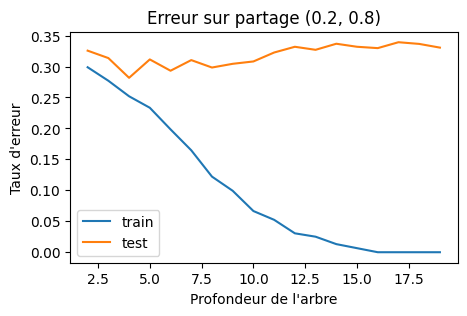

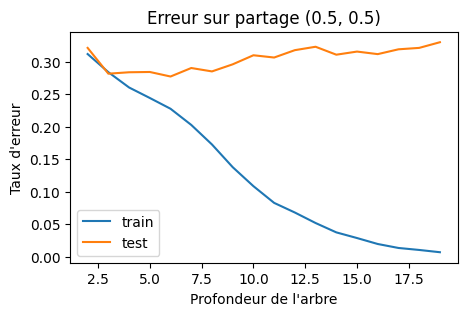

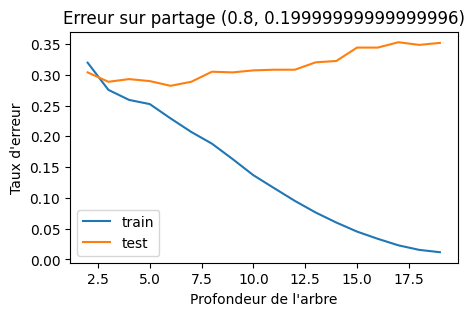

In [14]:
for t in [0.2, 0.5, 0.8]:
    taux_train = t
    np.random.shuffle(ind)

    ind_train = ind[:math.floor(N*t)]
    ind_test = ind[math.floor(N*t):]
    datax_train = datax[ind_train]
    datay_train = datay[ind_train]
    datax_test = datax[ind_test]
    datay_test = datay[ind_test]

    erreur_train = []
    erreur_test = []

    for i in profondeur:
        dt = DTree()
        dt.max_depth = i
        dt.min_samples_split = 2 #nombre minimum d’exemples pour spliter un noeud
        dt.fit(datax_train, datay_train)
        erreur_train.append(1- dt.score(datax_train, datay_train))
        erreur_test.append(1- dt.score(datax_test, datay_test))

    plt.figure(figsize=(5,3))
    plt.title("Erreur sur partage ("+str(t)+", "+str(1-t)+")")
    plt.xlabel("Profondeur de l'arbre")
    plt.ylabel("Taux d'erreur")
    plt.plot(profondeur, erreur_train, label="train")
    plt.plot(profondeur, erreur_test, label="test")
    plt.legend()
    plt.show()


## Questions


### Question 8

L'erreur sur le batch d'entrainement décroît au fur et à mesure que la profondeur de l'arbre augmente. On peut voir aussi que pour un batch d'entrainement petit, l'erreur semble décroître plus rapidement. L'erreur sur le batch de test semble être plutôt constante, autour de un tier.

### Question 9

...

# Partie 4

In [20]:
from sklearn.model_selection import cross_val_score

profondeur = range(2,15)
min = (1, 0)

for i in profondeur:
    print("Profondeur "+str(i)+" :")
    dt = DTree()
    dt.max_depth = i
    dt.min_samples_split = 2
    scores_list = cross_val_score(dt, datax, datay, cv=5)
    moy = 1- np.mean(scores_list)
    print(f"Erreur Moyenne : {moy}")

    if min[0] > moy:
        min = (moy, i)

print("\nMeilleure profondeur : ", min[1])
print("Pour une erreur de : ", min[0])

Profondeur 2 :
Erreur Moyenne : 0.3180744732159191
Profondeur 3 :
Erreur Moyenne : 0.2930038512436357
Profondeur 4 :
Erreur Moyenne : 0.2858081315647547
Profondeur 5 :
Erreur Moyenne : 0.2799212645193785
Profondeur 6 :
Erreur Moyenne : 0.27817810754496874
Profondeur 7 :
Erreur Moyenne : 0.27752261209827445
Profondeur 8 :
Erreur Moyenne : 0.2844999916845449
Profondeur 9 :
Erreur Moyenne : 0.2899499409602686
Profondeur 10 :
Erreur Moyenne : 0.2949646355573611
Profondeur 11 :
Erreur Moyenne : 0.3041199516278098
Profondeur 12 :
Erreur Moyenne : 0.3001976702470641
Profondeur 13 :
Erreur Moyenne : 0.30586287101778786
Profondeur 14 :
Erreur Moyenne : 0.30760674074549255

Meilleure profondeur :  7
Pour une erreur de :  0.27752261209827445
